# 건축과AI -  CNN 실습 자료

#### 본 실습자료는 크게 2가지 파트로 이뤄져 있습니다.
* Chapter 1. CNN 실습의 바이블이라 불리는 MNIST 데이셋을 활용하여 숫자 0~9를 분류(Classificer)하는 모델을 만드는 과정을 따라해보겠습니다.
* Chpater 2. U-net이라는 Semantic Segmentation 모델을 활용하여 시멘트의 크랙(crack)을 탐지하는 모델을 살펴보겠습니다.

#### Chapter 1.에서는 매우 간단한 모델을 직접 따라 구현해가면서 하나씩 살펴볼 것이며, Chapter 2.에서는 github에 공개되어 있는 데이터와 모델을 통해 그 결과를 살펴 보겠습니다.

- 수업에 들어기전에, 
    * 본 수업자료는 Jupyter notebook이라는 개발환경에서 작동합니다. 또한, 이를 goolge의 cloud service의 일종인 colab을 통해 실행합니다. 단일 코드의 실행은 'shift+Enter' 혹은 상단의 'Run' 버튼을 통해 실행 할 수 있습니다.
    * machine learning library로 pytorch를 사용하였습니다.
    * 본 수업자료는 따라하기 코드와 해당 코드에대한 간단한 설명을 적어두웠습니다.

---

* 아래는 본 실습에서 사용한 library입니다.

In [1]:
import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.optim import Adam

from os import listdir
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# Chapter 1. MNIST 예제로 실습하는 CNN

* 먼저 수업에서 사용할 MNIST라는 데이터를 다운받아오겠습니다.
* 아래의 코드를 실행해주세요

In [3]:
download_path = './MNIST_DS'
mnist_train_ds = datasets.MNIST(download_path, 
                                train=True, 
                                download=True,
                               transform=transforms.ToTensor())
clear_output()

---

* 다운받은 MNIST 데이터를 살펴보겠습니다. MNIST는 28 x 28 크기의 숫자(0~9) 이미지와 해당 이미지가 어떤 숫자인지 정답(label)이 달려있습니다.
* 아래의 코드는 MNIST 데이터중 앞의 10개를 출력하는 코드입니다. 실행해주세요.

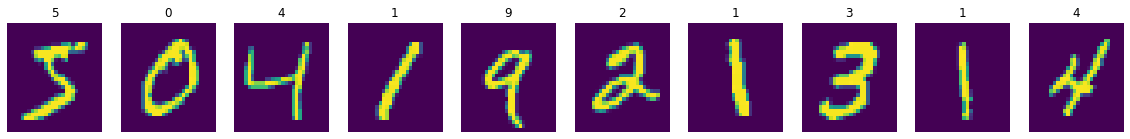

In [4]:
plt.figure(figsize=(20,2))
plt.tight_layout()
for idx in range(10):
    plt.subplot(1,10,idx+1)
    plt.imshow(mnist_train_ds[idx][0][0,:,:], aspect='auto')
    plt.title(mnist_train_ds[idx][1])
    plt.axis('off')
plt.show()

-> 출력 결과, 숫자 이미지와 해당 이미지의 정답을 확인할 수 있습니다.

---

#### Model 정의

* 이제 Model을 작성해보겠습니다. 이번 실습에서 사용할 모델은 아래와 같습니다. Conv2D, ReLU, MAX pooling등은 수업의 이론파트에서 배웠던 내용이며, 생각나지 않는 분들은 다시한번 복습하고 오시길 바랍니다.

* Input size (1 x 28 x 28) : 입력 이미지의 크기.
* Output size (10) : 10개의 숫자의 확률.
* Model의 구조.
    1. Conv2D x 16개
        - Filter : 3x3,  Padding : 1, Strides : 1  
        - 입력의 크기 : [1 x 28 x 28] => 출력의 크기 : [16 x 28 x 28]
    2. ReLU  
    3. MAX pooling
        - 입력의 크기 : [16 x 28 x 28] => 출력의 크기 : [16 x 14 x 14]
    4. Conv2D x 32개
        - filter : 3x3, padding : 1, strides : 1  
        - 입력의 크기 : [16 x 14 x 14] => 출력의 크기 : [32 x 14 x 14]
    5. ReLU  
    6. MAX pooling
        - 입력의 크기 : [32 x 14 x 14] => 출력의 크기 : [32 x 7 x 7]
    7. Flatten : 3차원의 데이터를 1차원의 데이터로 평평하게 만듬
        - 입력의 크기 : [32 x 7 x 7] => 출력의 크기 : [1568]
    8. MLP 1
        - 입력의 크기 : [1568] =>  출력의 크기 : [512]
    9. MLP 2
        - 입력의 크기 : [512] =>  출력의 크기 : [10]
    10. softmax

---

### Convolutional Layer 실습.
* 아래는 pytorch를 활용하여 2차원의 Convolutional laye(Conv2d)를 구현하는 함수입니다. (실행해주세요)

In [ ]:
test_conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1)

* 위의 Conv2d는 kernel size가 3입니다. 따라서, 학습 파라미터는 3x3입니다. 아래의 코드는 위의 Conv2d중 학습파라미터를 출력하는 코드입니다. 실행 해주세요.

In [ ]:
print(test_conv2d.weight)

Parameter containing:
tensor([[[[ 0.3180, -0.2551, -0.0908],
          [-0.1314, -0.3149,  0.2068],
          [ 0.1791,  0.0790,  0.0360]]]], requires_grad=True)


* 위의 출력결과 임의의 숫자로 초기화된 9개(3x3)의 값을 확인할 수 있습니다. 모델이 '학습한다'라는 것은 위의 파라미터 값들을 적절한 값으로 찾아가는 과정을 말합니다.
* 추가적으로 ReLU, Maxpooling, Flatten등은 아래와 같이 작성할 수 있습니다. (더 자세한 것은, Pytorch 홈페이지를 참고해주세요.)

In [ ]:
myReLU = nn.ReLU()
myMaxpool2d = nn.MaxPool2d(2, 2)
myFatten = nn.Flatten()

---

### Model 구현.
* pytorch에서는 Model을 구현하는 방법이 여러가지 있습니다. 그 중 nn.Sequential은 layer가 연속적(Sequential)으로 있을때, 편하게 구현할 수 있는 방법이다. 사용하는 방법은 아래와 같습니다.

In [ ]:
my_model = nn.Sequential(
    # A type Layer,
    # B type Layer,
    )

* 위의 Sequential을 활용하여, 예제 모델을 만들어 보겠습니다. (실행해주세요)

In [39]:
my_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(16, 32, 3, 1, 1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(1568, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
    nn.ReLU(),
    nn.Softmax(dim=-1))

* 만들어진 모델은 아래와 같이 구조를 출력할 수 있습니다.

In [ ]:
print(my_model)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1568, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=10, bias=True)
  (10): ReLU()
  (11): Softmax(dim=-1)
)


---

### Optimizer 정의

* 이제 모델을 모두 만들었고, 이를 최적화할 optimizer을 정의해보겠습니다. 현재 pytorch에서 제공하고 있는 optimizer의 종류는 아래와 같습니다.

In [ ]:
dir(torch.optim)[:12]

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam']

* 위의 optimizer들 중에서 본 예제에서는 가장 많이 사용되는 Adam을 사용할 것입니다.
* 그전에 pytoch에서는 optimizer에게 **어떤것**을 최적화하는지 알려줘야 합니다. 본 예제에서는 앞서 정의한 my_model의 학습파라미터가 되겠죠? 아래의 코드는 my_model의 학습해야할 파라미터를 출력하는 코드입니다. (실행해주세요.)

In [ ]:
list(my_model.parameters())

[Parameter containing:
 tensor([[[[-0.2312, -0.1688, -0.0262],
           [-0.0343,  0.0497, -0.2842],
           [ 0.2217,  0.2559, -0.2105]]],
 
 
         [[[ 0.1562, -0.2822, -0.0839],
           [ 0.0976, -0.0056, -0.3312],
           [ 0.1470,  0.1266,  0.2824]]],
 
 
         [[[-0.1840,  0.0473, -0.2441],
           [-0.2364,  0.0374,  0.0684],
           [-0.3219,  0.2477, -0.2573]]],
 
 
         [[[-0.0183,  0.1535,  0.0708],
           [-0.2833,  0.0957, -0.0031],
           [ 0.2115, -0.0633,  0.2689]]],
 
 
         [[[ 0.2382,  0.2706,  0.2995],
           [-0.1267,  0.0681,  0.0717],
           [ 0.2535, -0.0941, -0.2819]]],
 
 
         [[[-0.3096, -0.1526, -0.2603],
           [-0.0287,  0.2717, -0.2031],
           [-0.1642, -0.0105, -0.2141]]],
 
 
         [[[ 0.2876, -0.3119, -0.0784],
           [ 0.0384,  0.1838, -0.3205],
           [ 0.0598, -0.2137, -0.0250]]],
 
 
         [[[-0.1038, -0.1719, -0.1152],
           [ 0.2143,  0.3105,  0.1190],
           [-0.

* 위의 출력된 파라미터들은 모델의 학습을 통해 최적화해야 할 값들이며, 아래와 같이 이를 optimizer에게 알려줌으로서 optimizer를 정의할 수 있습니다. 

In [ ]:
my_Adam = torch.optim.Adam(my_model.parameters() ,lr=0.001)

### Loss function 정의

* 마지막으로 loss function을 정의해보겠습니다. machine learning에는 수많은 loss function이 있는데, 이제 가장 많이 사용되는 MSE와 BCE를 살펴보겠습니다.

In [ ]:
input_a = torch.Tensor([0.2,0.2,0.6])
input_b = torch.Tensor([0.1,0.6,0.3])

* 위의 코드에서 임시로 2개의 벡터를 만들었습니다. 두 벡터의 MSE loss는 아래의 코드를 통해 구할 수 있습니다.

In [ ]:
mse_loss = F.mse_loss(input_a, input_b)
print(f'MSE Loss : {mse_loss}')

MSE Loss : 0.08666668087244034


* 이번에는 같은 데이터에 다른 loss인 BCE를 적용한 결과 입니다.

In [ ]:
BCE_loss = F.binary_cross_entropy(input_a, input_b)
print(f'BCE Loss : {BCE_loss}')

BCE Loss : 0.7371148467063904


---

### 중간정리.
* 지금까지 Model, loss function, optimizer등을 만드는 방법을 배웠습니다. 본 실습예제에서 다룬 것들외에도 정말 많은 방법들이 존재하며 홈페이지에서 찾아볼 수 있습니다.

* 이를 통해 training하는 과정을 아래와 같이 구현하였습니다. training 과정은 python지식도 필요한만큼, 간단하게 흐름을 파악할 수 있게 주석을 표시해 두웠습니다. 

### Training 정의

In [6]:
BATCH_SIZE = 32
EPOCH = 10

In [7]:
# --- optimizer 정의.
my_Adam = torch.optim.Adam(my_model.parameters() ,lr=0.001)

# --- model을 학습모드로 전환
my_model.train()

# --- dataloader 정의.
train_loader = DataLoader(mnist_train_ds, batch_size=BATCH_SIZE)

# --- 계산된 loss를 저장할 곳.
losses = []

# --- EPOCH만큼 반복
for epoch_idx in range(EPOCH):
    print('=== epoch {} start === \n'.format(epoch_idx+1))
    print('before train, conv2d 1 value : {} \n'.format(list(my_model.modules())[0][0].weight[0,:,:,:].data))
    epoch_loss = 0
    
    # --- Batch 단위 학습. 
    for idx, (x, y) in enumerate(train_loader):
        print('iteration : {}\n'.format(idx+1))
        my_Adam.zero_grad() # --- 새로운 gradient를 구하기 전에 gradient 초기화
        y_hat = my_model(x) # --- output 계산.
        y_real = F.one_hot(y, 10).float() # --- one hot encoding 변환.
        loss = F.binary_cross_entropy(y_hat, y_real) #  --- loss 계산.
        epoch_loss = epoch_loss + loss.data.numpy() # --- batch단위 loss 누적
        print('loss value : {} \n'.format(loss))
        loss.backward() # --- 역전파를 흘려서 gradient 계산
        print('gradient, conv2d 1 value : {} \n'.format(list(my_model.modules())[0][0].weight.grad[0,:,:,:].data))
        my_Adam.step() # --- 학습파라미터 업데이트.
        break # --- 실습용 한번만 돌고 빠져나오기
    losses.append(epoch_loss/(idx+1))
    print('After train, conv2d 1 value : {} \n'.format(list(my_model.modules())[0][0].weight[0,:,:,:].data))    
    break # --- 실습용 한번만 돌고 빠져나오기

=== epoch 1 start === 

before train, conv2d 1 value : tensor([[[-0.0458,  0.1541, -0.1993],
         [-0.0129,  0.0215, -0.2898],
         [-0.1221, -0.1132, -0.3101]]]) 

iteration : 1

loss value : 0.32519078254699707 

gradient, conv2d 1 value : tensor([[[ 2.3105e-07, -3.3584e-05,  1.7068e-05],
         [-1.9016e-05, -1.6978e-05,  3.8645e-06],
         [-4.3749e-05, -1.3912e-05, -2.6654e-05]]]) 

After train, conv2d 1 value : tensor([[[-0.0468,  0.1551, -0.2003],
         [-0.0119,  0.0225, -0.2908],
         [-0.1211, -0.1122, -0.3091]]]) 



* 위의 출력결과를 정리해보겠습니다.
 - before train : 학습 전의 1번째 Conv2D의 학습 파라미터.
 - iteratio : 1번째 루틴.
 - loss value : trainset으로 구한 loss 값.
 - gradient : 위에서 구한 loss value을 통해 계산한 1번째 Conv2D의 Gradient
 - After train : 학습 후 1번째 Conv2D의 학습 파라미터. Before train과 비교하면, 값이 학습되었음을 확인할 수 있다.

### 학습.
* 실제 학습을 진행해보곘습니다. 
* 학습전 모델의 성능을 확인해보겠습니다.

before training


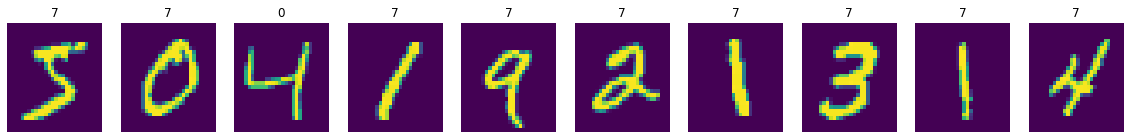

In [33]:
print('before training')
plt.figure(figsize=(20,2))
plt.tight_layout()
for idx in range(10):
    plt.subplot(1,10,idx+1)
    plt.imshow(mnist_train_ds[idx][0][0,:,:], aspect='auto')
    plt.title(torch.argmax(my_model(mnist_train_ds[idx][0].unsqueeze(0))).numpy())
    plt.axis('off')
plt.show()

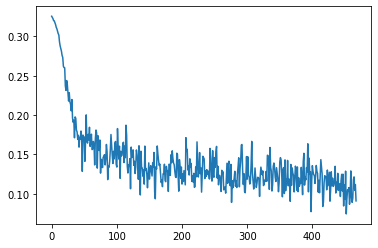

In [40]:
EPOCH = 1

my_Adam = torch.optim.Adam(my_model.parameters() ,lr=0.0005)
train_loader = DataLoader(mnist_train_ds, batch_size=128, drop_last=True)
losses, train_loss = [], []

fig = plt.figure()

for epoch_idx in range(EPOCH):
    epoch_loss = 0
    for idx, (x, y) in enumerate(train_loader):
        my_Adam.zero_grad() # --- 새로운 gradient를 구하기 전에 gradient 초기화
        y_hat = my_model(x) # --- output 계산.
        y_real = F.one_hot(y, 10).float() # --- one hot encoding 변환.
        loss = F.binary_cross_entropy(y_hat, y_real) #  --- loss 계산.
        train_loss.append(loss.data.numpy())
        epoch_loss = epoch_loss + loss.data.numpy() # --- batch단위 loss 누적
        loss.backward() # --- 역전파를 흘려서 gradient 계산
        my_Adam.step() # --- 학습파라미터 업데이트.

        plt.plot(range(len(train_loss)), train_loss)
        plt.draw()
        clear_output(wait=True)  
        plt.show()

After training


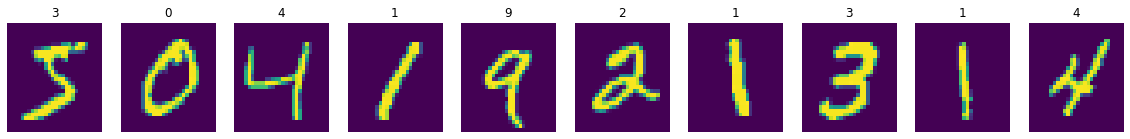

In [41]:
print('After training')
plt.figure(figsize=(20,2))
plt.tight_layout()
for idx in range(10):
    plt.subplot(1,10,idx+1)
    plt.imshow(mnist_train_ds[idx][0][0,:,:], aspect='auto')
    plt.title(torch.argmax(my_model(mnist_train_ds[idx][0].unsqueeze(0))).numpy())
    plt.axis('off')
plt.show()

In [19]:
from crack import *

train_ds = my_dataset('data/train/')
test_ds = my_dataset('data/test/')

* 참고자료.
    - 모델구조 및 pretrained parameter = https://github.com/khanhha/crack_segmentation
    - 효율적인 코드 작성. https://www.pytorchlightning.ai

* Chapter 1에서 간단한 예제를 다뤄봤다면, Chapter 2에서는 이를 건축분야에 적용한 application을 다뤄보겠습니다. 이번실습에서는 U-net 을 통해 crack을 구분해보겠습니다.
* machine learning을 비롯한 computer science 분야에서는 오픈플랫폼이 활성화 되어있습니다. 또한, 성능이 좋은 deep learning 모델의 경우, 복수의 GPU을 이용하여 몇일 학습해야 하는 경우가 빈번합니다. 따라서 github등에서 구현된 모델과 학습된 결과를 가져와 활용하는 능력은 중요합니다.
* 해당 예제도 위에서 언급된 github의 내용을 가져왔습니다.

* Unet model
![Unet](img/Unet_model.png)

* 데이터의 상태를 살펴보겠습니다.

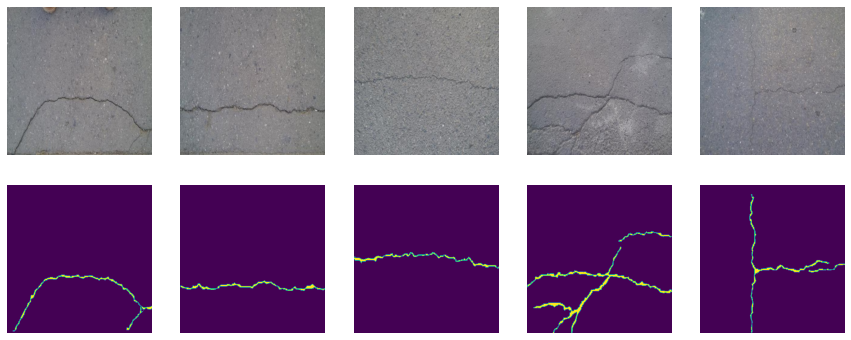

In [17]:
plt.figure(figsize=(15,6))
plt.tight_layout()
for idx in range(5):
    plt.subplot(2,5,idx+1)
    plt.imshow(np.array(Image.open('data/train/images/'+train_ds.img_name_list[idx]+'.jpg')), aspect='auto')
    plt.axis('off')
    plt.subplot(2,5,idx+6)
    plt.imshow(np.array(Image.open('data/train/masks/'+train_ds.img_name_list[idx]+'.jpg')), aspect='auto')
    plt.axis('off')
plt.show()

* 위와 같이 데이는 crack의 사진(X)과 해당하는 크랙이 구분되어 있는 정답(Y)로 이뤄져있습니다.

### model

* 아래는 먼저 정의한 모델을 불러오는 과정입니다.(실행해주세요)

In [48]:
my_crack_model = UNet16(pretrained=False)

* 출력을 통해 모델의 구조를 살펴보겠습니다.

In [21]:
print(my_crack_model)

UNet16(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15)

### 학습전의 모델의 성능

* 아직 모델은 학습되기 전 상태입니다. 학습전 모델의 성능을 확인해보겠습니다.

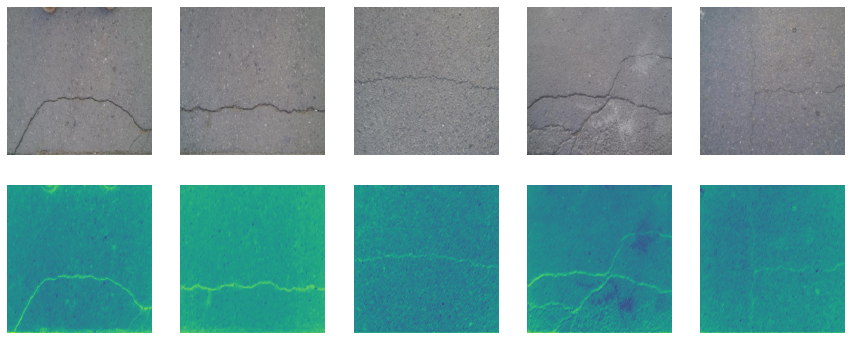

In [50]:
train_img_ds = torch.stack([train_ds[i][0] for i in range(5)])
#forward_rst = F.sigmoid(my_crack_model(train_img_ds))
forward_rst = my_crack_model(train_img_ds)

plt.figure(figsize=(15,6))
plt.tight_layout()
for idx in range(5):
    plt.subplot(2,5,idx+1)
    plt.imshow(np.array(Image.open('data/train/images/'+train_ds.img_name_list[idx]+'.jpg')), aspect='auto')
    plt.axis('off')
    plt.subplot(2,5,idx+6)
    plt.imshow(np.array((forward_rst[idx][0]).detach().numpy()), aspect='auto')
    plt.axis('off')
plt.show()

* 위의 결과에서 아직 model이 crack부분만 체크하고 있지는 못합니다.

### 학습 후의 모델의 성능

* 이번에는 학습을 마친 모델의 결과를 살펴보겠습니다. 모델의 학습 시간이 너무 길고 GPU가 많이 필요하기 때문에 별도로 학습을 완료한 모델을 불러와 확인하였습니다.

In [43]:
my_crack_model.load_state_dict(torch.load('model_unet_vgg_16_best.pt',map_location=torch.device('cpu'))['model'])

<All keys matched successfully>

* 다시한번 성능을 평가해보겠습니다.

/Users/donghyeok/anaconda3/envs/pytorch16/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


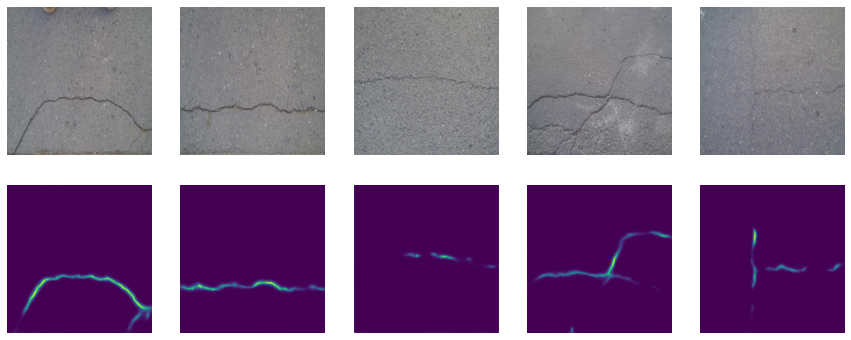

In [44]:
train_img_ds = torch.stack([train_ds[i][0] for i in range(5)])
forward_rst = torch.sigmoid(my_crack_model(train_img_ds))

plt.figure(figsize=(15,6))
plt.tight_layout()
for idx in range(5):
    plt.subplot(2,5,idx+1)
    plt.imshow(np.array(Image.open('data/train/images/'+train_ds.img_name_list[idx]+'.jpg')), aspect='auto')
    plt.axis('off')
    plt.subplot(2,5,idx+6)
    plt.imshow(np.array((forward_rst[idx][0]).detach().numpy()), aspect='auto')
    plt.axis('off')
plt.show()

### Test set에서의 성능
* 이번에는 학습에 사용되지 않았던 데이터들의 결과를 살펴보겠습니다.

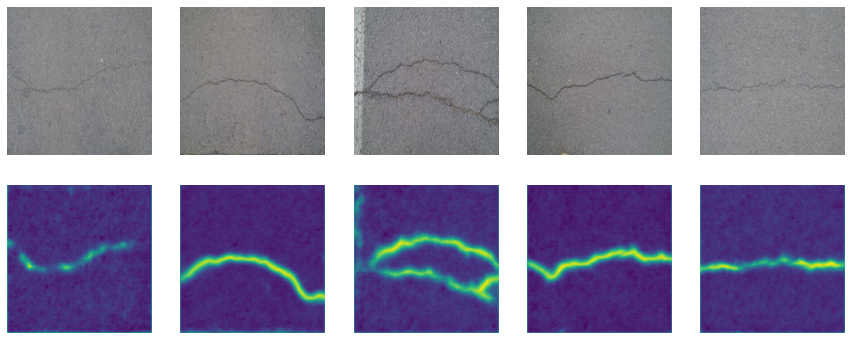

In [46]:
test_img_ds = torch.stack([test_ds[i][0] for i in range(5)])
#forward_rst = torch.sigmoid(my_crack_model(test_img_ds))
forward_rst = my_crack_model(test_img_ds)

plt.figure(figsize=(15,6))
plt.tight_layout()
for idx in range(5):
    plt.subplot(2,5,idx+1)
    plt.imshow(np.array(Image.open('data/test/images/'+test_ds.img_name_list[idx]+'.jpg')), aspect='auto')
    plt.axis('off')
    plt.subplot(2,5,idx+6)
    plt.imshow(np.array((forward_rst[idx][0]).detach().numpy()), aspect='auto')
    plt.axis('off')
plt.show()